# Transformaciones espaciales

Las categorías principales de procesamiento espacial son las transformaciones de intensidad y los filtros espaciales, pueden ser denotados con la expresión:
$$
g(x,y) = T[f(x,y)]
$$
donde $f(x,y)$ es la imagen de entrada, $g(x,y)$ es la imagen de salida. y $T$ es un operador en $f$ definido sobre un vecindario del punto $(x,y)$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from pydicom import dcmread

Imagen con la que se aplican todas las transformaciones

In [2]:
img = dcmread('data/sample/1/d9a40467af6c649351914bd8c6fe71c4.dicom').pixel_array

In [3]:
def dcm_show_transform(array, titles=None):
    if titles is None:
        titles = ['Transform' for _ in range(len(array))]
    if len(titles) < len(array):
        for _ in range(len(array) - len(titles)):
            titles.append('Transform')

    array.insert(0, img)
    titles.insert(0, 'Original Image')
        
    plt.figure(figsize=(4 * len(array), 4))
    
    for i in range(len(array)):
        plt.subplot(1, len(array), i + 1)
        plt.title(titles[i])
        plt.axis('off')
        plt.imshow(array[i], cmap=plt.gray())

In [4]:
def dcm_hist(array, bins=328):
    # array.insert(0, img)
    
    fig, ax = plt.subplots(len(array), figsize=(8, 4 * len(array)))
    left  = np.max(array[-1]) * -.05
    right = np.max(array[-1]) * 1.05
    
    if len(array) > 1:
        for i in range(len(array)):
            ax[i].hist(array[i].ravel(), bins=bins, histtype='stepfilled', color='xkcd:sky blue')
            ax[i].set_xlim((left, right))
            ax[i].set_yscale('log')
    else:
        ax.hist(array[0].ravel(), bins=bins, histtype='stepfilled', color='xkcd:sky blue')
        ax.set_xlim((left, right))
        ax.set_yscale('log')
    
    plt.show()

## Negativo

$$
    s = L-1-r,\quad r\in [0, L-1]
$$

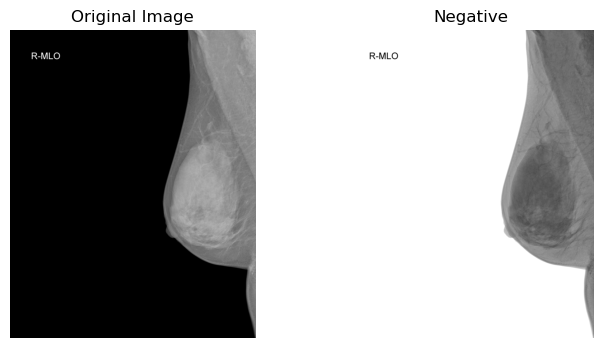

In [5]:
inv = cv.bitwise_not(img)
dcm_show_transform([inv], ['Negative'])

## Transformación log

$$
    s = c \log(1+r), \quad c = \frac{f_{max}-f_{min}}{\log (f_{max}-f_{min})}
$$

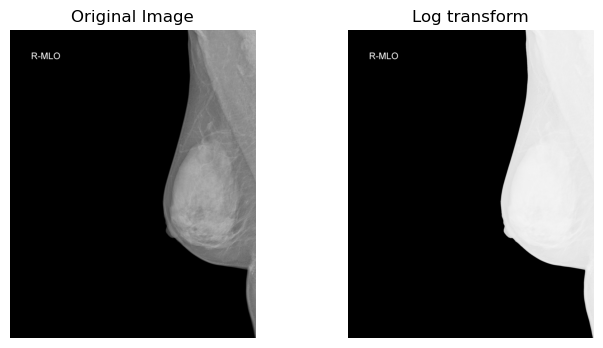

In [6]:
delta = np.ptp(img)
c = delta / np.log(delta)
log = c * np.log(1 + img)

dcm_show_transform([log], ['Log transform'])

## Transformación gamma

$$
    s = cr^\gamma
$$

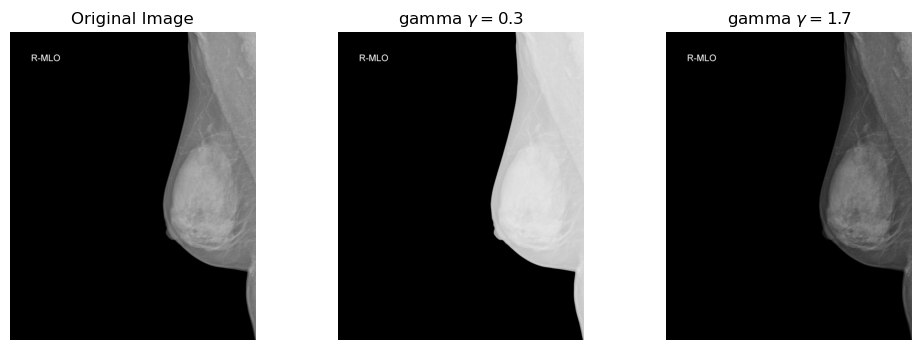

In [7]:
# from matplotlib.widgets import Button, Slider
gamma = 0.7

pwr = np.power(img / delta, (1 - gamma)) * delta 
sqrt = np.power(img / delta, (1 + gamma)) * delta
dcm_show_transform([pwr, sqrt], 
                   [r'gamma $\gamma=' + str(round(1 - gamma, 2)) + '$', 
                    r'gamma $\gamma=' + str(round(1 + gamma, 2)) + '$'])

## Contrast stretching

$$
    s = \frac{r - f_{min}}{f_{max} - f_{min}}
$$

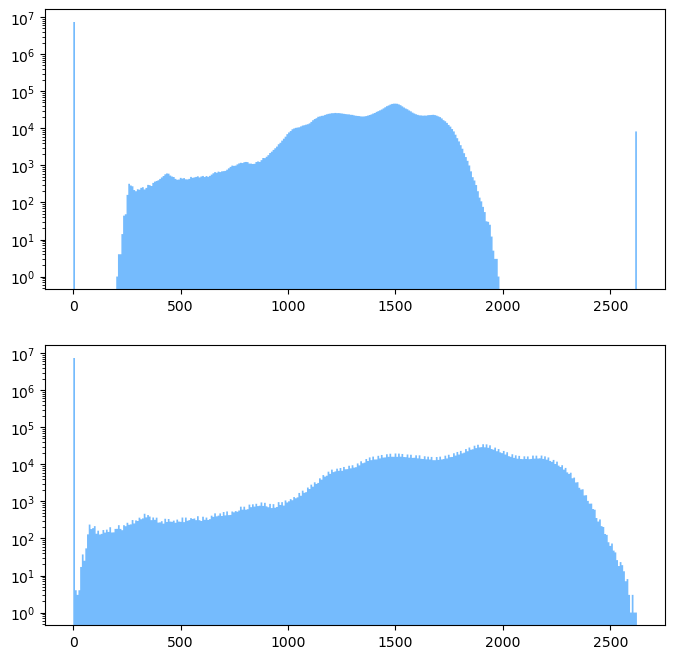

In [8]:
lb = np.min(img[img > 0])
ub = np.max(img[img < np.max(img)])
# Transforma el texto descriptivo de la vista (MLO, CC) de blanco a negro
stretch = np.where((0 < img) & (img < np.max(img)), (img - lb) / (ub - lb), 0) * np.max(img)

dcm_hist([img, stretch])

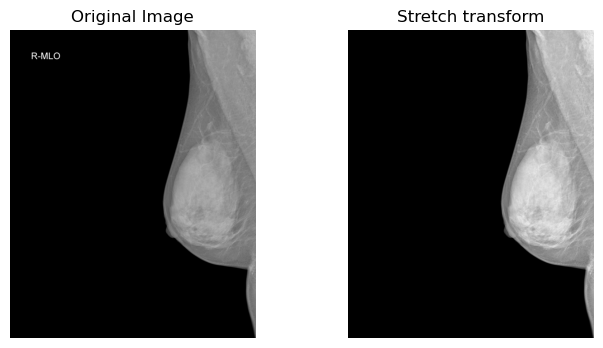

In [9]:
dcm_show_transform([stretch], ['Stretch transform'])

## Intensity-level slicing

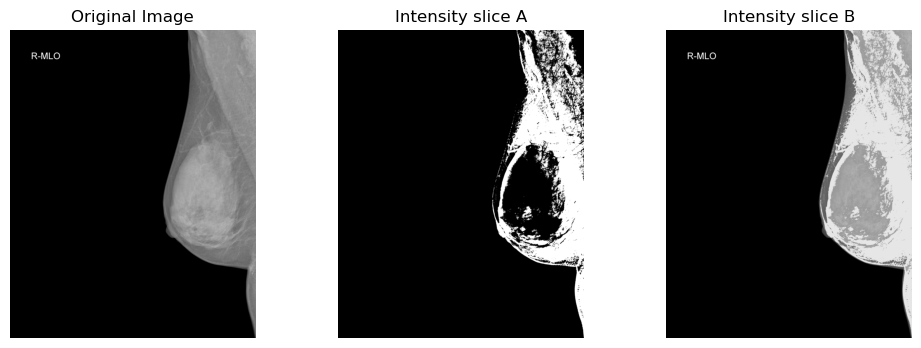

In [10]:
lb = np.max(img) * 0.425
ub = np.max(img) * 0.575
intensity = np.max(img) * 0.9

slicedA = np.where((lb < img) & (img < ub), intensity, lb)
slicedB = np.where((lb < img) & (img < ub), intensity, img)

dcm_show_transform([slicedA, slicedB], ['Intensity slice A', 'Intensity slice B'])

## Histogram equalization

$$
    s = T(r) = (L-1) \int_{0}^{r} P_{r}(w)dw
$$
Forma discreta:
$$
    s_{k} = T(r_{k}) = (L-1) \sum_{j=0}^{k} p_{r}(r_{j}) \qquad k=0,1,2,\cdots,L-1
$$

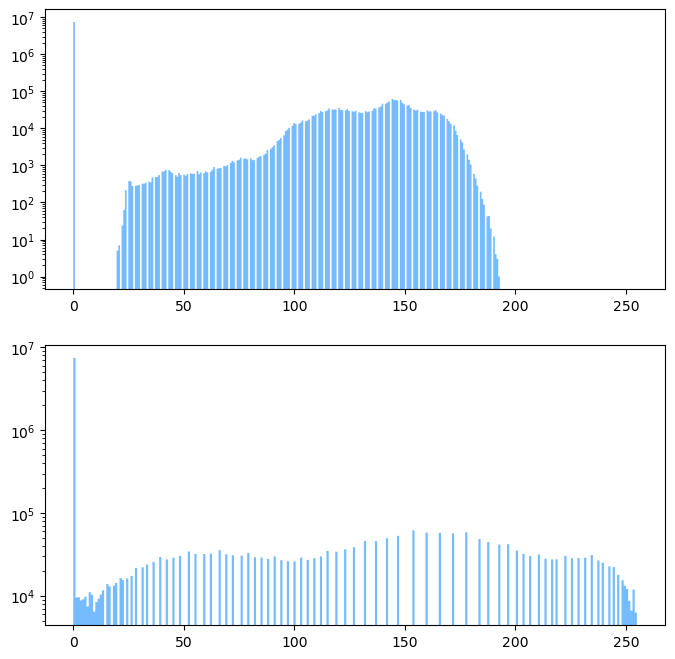

In [11]:
ratio = np.amax(img) / 256
prep = (img / ratio).astype(np.uint8)
hist_eq = cv.equalizeHist(prep)

dcm_hist([prep, hist_eq], bins=256)

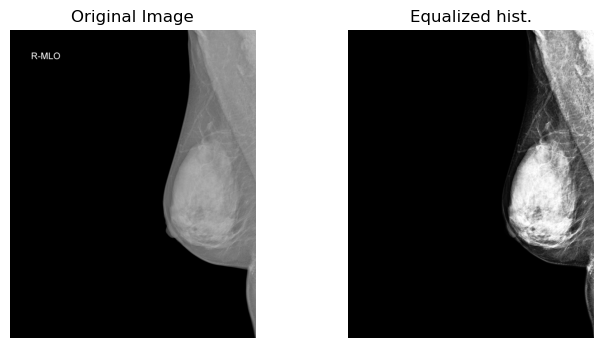

In [12]:
dcm_show_transform([hist_eq], ['Equalized hist.'])

## CLAHE

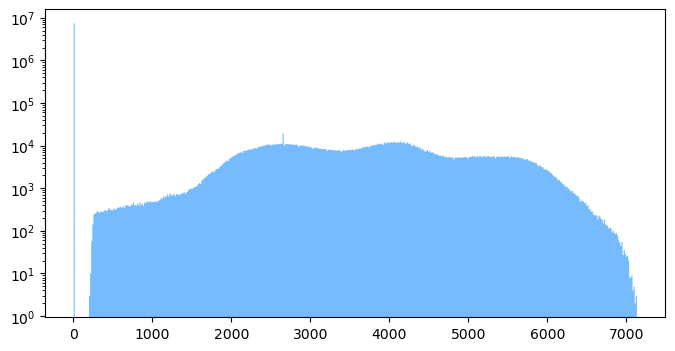

In [13]:
clahe = cv.createCLAHE(5, (4, 4))

dcm_clahe = clahe.apply(img)
dcm_hist([dcm_clahe], bins=512)

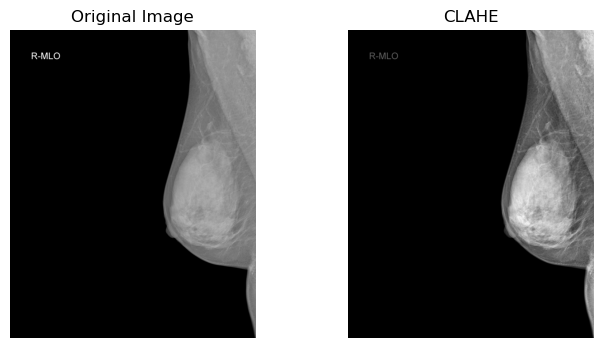

In [14]:
dcm_show_transform([dcm_clahe], ['CLAHE'])

# Filtros espaciales

Los filtros espaciales lineales ejecutan operación entre una imagen $f$ y un *kernel de filtro* ($w$). El kernel es un arreglo que define el vecindario de la operación, y sus coeficientes definen la naturaleza del filtro. La respuesta $g(x, y)$ del filtro es la suma de productos de los coeficientes del kernel y los píxeles de la imagen enmarcados dentro del kernel.

Correlación espacial
$$
    (w \star f)(x, y) = \sum_{s=-a}^{a} \sum_{t=-b}^{b} w(s, t) f(x+s, y+t)
$$
Convolución espacial
$$
    (w \star f)(x, y) = \sum_{s=-a}^{a} \sum_{t=-b}^{b} w(s, t) f(x-s, y-t)
$$

## Average filter
Filtro usando la media
$$
    K = \frac{1}{9} 
    \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1 
    \end{bmatrix}
$$

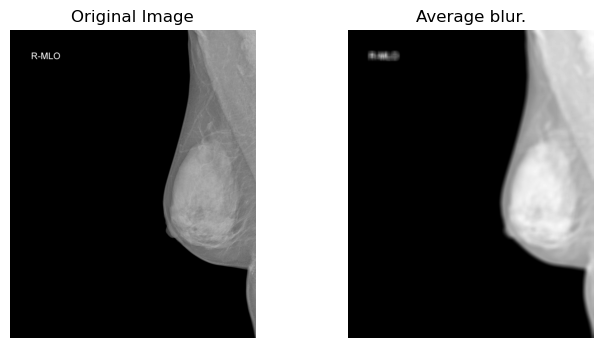

In [15]:
blur = cv.blur(img, (55, 55))

dcm_show_transform([blur], ['Average blur.'])

## Median filter

Filtro usando la mediana


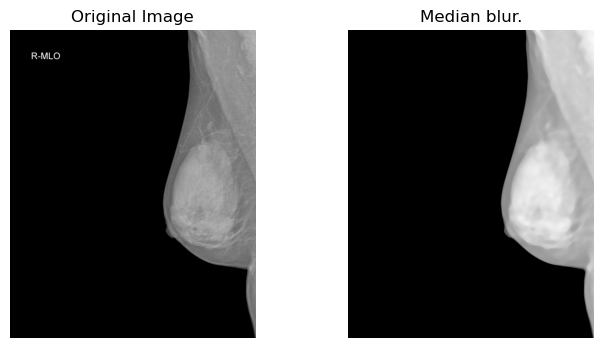

In [16]:
ratio = np.amax(img) / 256
prep = (img / ratio).astype(np.uint8)
median = cv.medianBlur(prep, 55)

dcm_show_transform([median], ['Median blur.'])

## Gaussian Blur

Suavizado con función gaussiana

$$
G_0(x,y) = Ae^{X + Y},\qquad X = \frac{-(x-\mu_x)^2}{2\sigma^2_x}, Y = \frac{-(y-\mu_y)^2}{2\sigma^2_y} 
$$

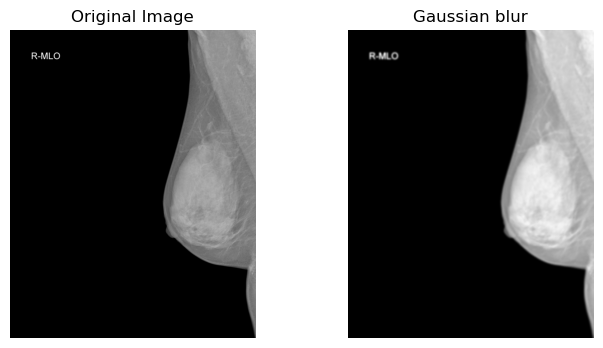

In [17]:
gauss = cv.GaussianBlur(img, (55, 55), 0)
dcm_show_transform([gauss], ['Gaussian blur'])

## Operadores diferenciales
Forma básica del uso del Laplaciano en imágenes
$$
g(x,y) = f(x,y) + c \left[ \nabla^2 f(x,y) \right], \quad \nabla^2 = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} 
$$
Un kernel para filtro laplaciano
$$
    K =
    \begin{bmatrix}
    0 & 1 & 0 \\
    1 & -4 & 1 \\
    0 & 1 & 0 
    \end{bmatrix}
$$


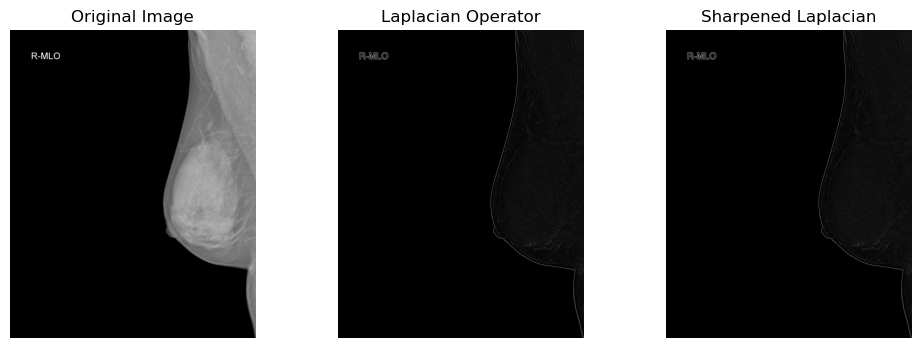

In [18]:
laplus = cv.Laplacian(img, cv.CV_16U, ksize=7)
sharp = cv.addWeighted(img, 0.1, laplus, 0.9, 0)

dcm_show_transform([laplus, sharp], ['Laplacian Operator', 'Sharpened Laplacian'])

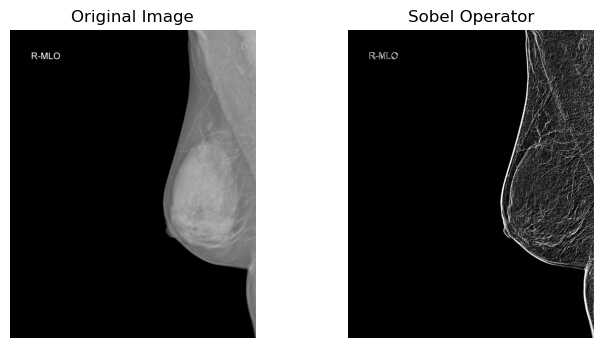

In [19]:
sobelX = cv.Sobel(img, cv.CV_16U, 1, 0, ksize=7)
sobelY = cv.Sobel(img, cv.CV_16U, 0, 1, ksize=7)
sobel = cv.bitwise_or(sobelX, sobelY)

dcm_show_transform([sobel], ['Sobel Operator'])